In [39]:
import pandas as pd

# Read the data
df = pd.read_csv('../../../Data/cleaned_dataset.csv')

df.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx,Real Oil Prices
0,12.962951,12.750812,5.803950,19.534471,17.325209,5.952564,6.137924,6.101171,6.327298,5.854031,...,5.861682,3.571677,3.772941,3.498251,6.104337,15.967271,17.533756,9.539485,4.091742,13.715729
1,12.965336,12.751983,5.806582,19.540266,17.320880,5.964607,6.150103,6.113980,6.340179,5.883401,...,5.865968,3.575312,3.782409,3.500802,6.247928,15.942881,17.542367,9.549875,4.019942,13.601725
2,12.970718,12.755952,5.807793,19.549848,17.329560,5.975704,6.160908,6.124948,6.353748,5.910003,...,5.871375,3.580145,3.783457,3.505891,6.270529,15.972082,17.542547,9.562213,4.016897,14.512195
3,12.978406,12.763876,5.815217,19.537241,17.337448,5.980389,6.168790,6.133329,6.363083,5.954359,...,5.873100,3.581351,3.783457,3.509696,6.307429,15.924905,17.543025,9.580477,3.880490,15.017895
4,12.984426,12.770292,5.819106,19.552370,17.341493,5.981250,6.165329,6.128931,6.356100,5.934182,...,5.875166,3.586164,3.794936,3.512227,6.329124,15.943545,17.556218,9.597480,3.882946,15.981442


#### 1. Splitting Data into Train and Test Sets

In [40]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Split features and target variable
X = df.drop('Real Oil Prices', axis=1)
y = df['Real Oil Prices']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 2. Grid Search for Algorithm Tuning

In [41]:
from sklearn.ensemble import RandomForestRegressor

# Hyperparameters grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt']
}

# Initialize the base model
base_rf = RandomForestRegressor(random_state=42)

# Grid search
#  By default, GridSearchCV uses the default scorer of the estimator (in the case of RandomForestRegressor, it's R^2).
grid_search = GridSearchCV(estimator=base_rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print(f"Best Parameters from Grid Search: {best_params}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits


Best Parameters from Grid Search: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 50}


#### 3. Creating and Training the Random Forest Regressor and Predict

In [42]:
# Train RF with best parameters
# The ** operator lets us pass a dictionary as keyword arguments
# unpacks the dictionary(best_params) into individual parameters that RF expects
best_rf = RandomForestRegressor(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

# Make predictions
predictions = best_rf.predict(X_test)

### Evaluation Metrics

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nModel Evaluation after Grid Search:")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2}")


Model Evaluation after Grid Search:
Mean Absolute Error: 0.9367712430724863
Mean Squared Error: 1.388020559131755
Root Mean Squared Error: 1.17814284326297
R^2 Score: 0.9791874827770349


### Feature Importance

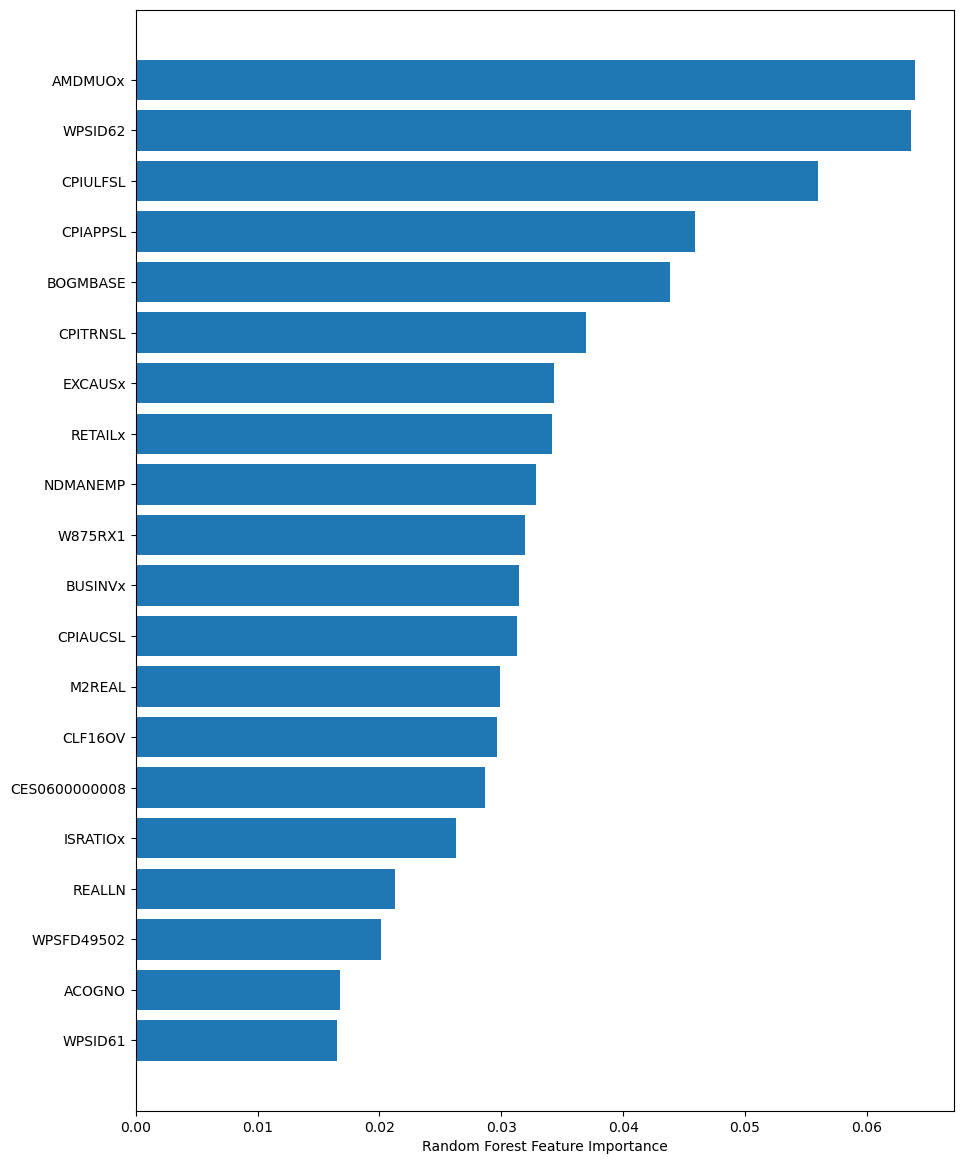

In [44]:
importances = best_rf.feature_importances_
features = X.columns

# Sorting feature importances
sorted_idx = importances.argsort()

# Selecting top 20
top_20_idx = sorted_idx[-20:]

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 12))
plt.barh(range(20), importances[top_20_idx])
plt.yticks(range(20), features[top_20_idx], fontsize=10) 
plt.xlabel("Random Forest Feature Importance")
plt.tight_layout(pad=2) 
plt.show()

### Learning Curve Attempt

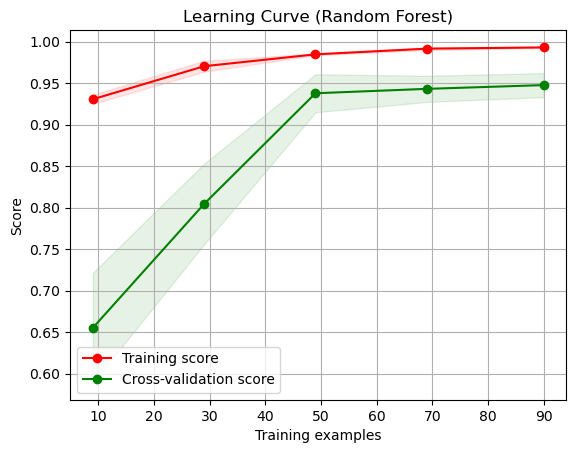

In [45]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

plot_learning_curve(best_rf, "Learning Curve (Random Forest)", X_train, y_train, cv=5)
plt.show()

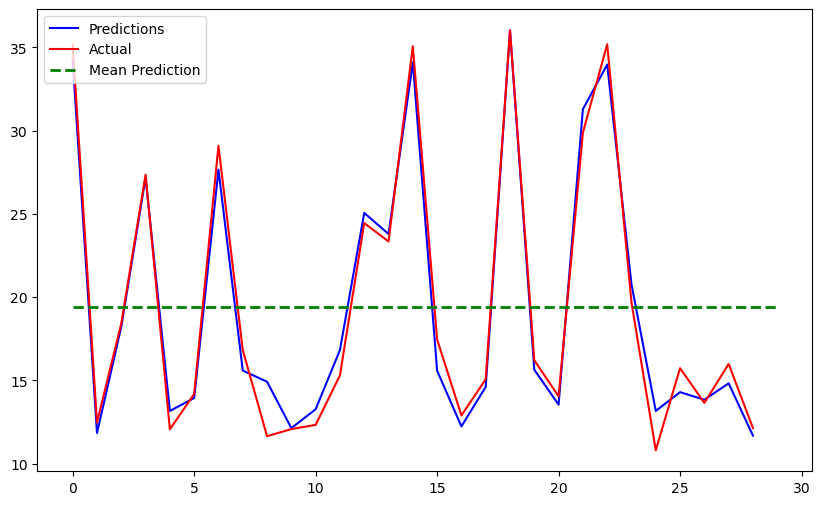

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(predictions, label='Predictions', color='blue')
plt.plot(y_test.values, label='Actual', color='red')

# Mean Prediction line
plt.plot([0, len(y_test)], [predictions.mean(), predictions.mean()], '--', lw=2, color='green', label='Mean Prediction')

plt.legend(loc='upper left')
plt.show()

### Save Model using joblib instead of pickle because it is more efficient for storing large numpy arrays such as the one we have here.

In [1]:
import joblib

# Save the model to a file
joblib.dump(best_rf, 'rf_model.pkl')

NameError: name 'best_rf' is not defined